In [1]:
# ==============================================================================
# 0. REPOSITORY SETUP
# ==============================================================================
# The 'source' folder contains the official BABILong benchmark utility scripts.
# If the folder is missing (e.g., running on a fresh Colab instance), uncomment:
# !git clone https://github.com/booydar/babilong source

In [2]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================
import torch
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# --- Hugging Face ---
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# --- Local Benchmark Modules ---
# We append 'source' to the path to ensure Python finds the internal modules
import sys
if "./source" not in sys.path:
    sys.path.append("./source")

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

# ==============================================================================
# 2. SYSTEM CHECKS
# ==============================================================================
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"Evaluation Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: Running on CPU. Evaluation will be extremely slow.")

PyTorch Version: 2.6.0+cu124
Evaluation Device: NVIDIA GeForce RTX 3080


In [4]:
# ==============================================================================
# 3. PROMPT CONFIGURATION
# ==============================================================================
# We define the prompt structure to match exactly what the model saw during training.
# Consistency between Training and Evaluation is vital for valid results.

TASK_NAME = 'qa1'
TRIGGER_PHRASE = "The most recent location of"
TRIGGER_SUFFIX = f"\nAnswer: {TRIGGER_PHRASE}"

# Load default prompt components from the benchmark
prompt_cfg = {
    'instruction': DEFAULT_PROMPTS[TASK_NAME]['instruction'],
    'examples': DEFAULT_PROMPTS[TASK_NAME]['examples'],
    'post_prompt': DEFAULT_PROMPTS[TASK_NAME]['post_prompt'],
    
    # CRITICAL: We append the same trigger used in training.
    # This aligns the inference state with the fine-tuned behavior, 
    # prompting the model to complete the sentence starting with the name.
    'template': DEFAULT_TEMPLATE + TRIGGER_SUFFIX,
}

print(f"✅ Prompt Configured for Task: {TASK_NAME}")
print(f"▶ Template End: '...{prompt_cfg['template'][-50:]}'")

✅ Prompt Configured for Task: qa1
▶ Template End: '...on: {question}
Answer: The most recent location of'


In [5]:
# ==============================================================================
# 3. MODEL LOADING (Baseline vs. Fine-Tuned)
# ==============================================================================
import torch
from pathlib import Path
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

# --- CONFIGURATION TOGGLE ---
# Set to TRUE to load your fine-tuned adapter.
# Set to FALSE to evaluate the original Mamba model (Baseline).
USE_ADAPTER = False  

# Constants
BASE_MODEL_ID = "state-spaces/mamba-1.4b-hf"
ADAPTER_PATH = Path("../babilong_mamba_finetune").resolve() # Relative path

# 1. Load the Base Model (Always required)
print(f"⏳ Loading Base Model: {BASE_MODEL_ID}...")
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    device_map={"": torch.cuda.current_device()},
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

if USE_ADAPTER:
    # 2A. Load Adapter (Fine-Tuned Mode)
    print(f"🔗 Attaching LoRA Adapter from: {ADAPTER_PATH}")
    
    if not (ADAPTER_PATH / "adapter_config.json").exists():
        # Fallback check for different folder structures
        ADAPTER_PATH = Path("../Pretraining/babilong_mamba_finetune").resolve()
        
    if not (ADAPTER_PATH / "adapter_config.json").exists():
        raise FileNotFoundError(f"❌ Adapter not found at {ADAPTER_PATH}")

    model = PeftModel.from_pretrained(model, str(ADAPTER_PATH))
    
    # Load the tokenizer associated with the adapter (ensures special tokens match)
    tokenizer = AutoTokenizer.from_pretrained(str(ADAPTER_PATH))
    print("✅ Fine-Tuned Model Loaded Successfully.")

else:
    # 2B. Base Model Only (Baseline Mode)
    print("ℹ️  Running in Baseline Mode (No Adapter).")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    tokenizer.pad_token = tokenizer.eos_token # Ensure padding works for base model too
    print("✅ Base Model Loaded Successfully.")

# Switch to eval mode (crucial for deterministic results)
model.eval()

⏳ Loading Base Model: state-spaces/mamba-1.4b-hf...


`torch_dtype` is deprecated! Use `dtype` instead!
The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation for mamba-ssm and install the kernels library using `pip install kernels` or https://github.com/Dao-AILab/causal-conv1d for causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ℹ️  Running in Baseline Mode (No Adapter).
✅ Base Model Loaded Successfully.


MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 2048)
    (layers): ModuleList(
      (0-47): 48 x MambaBlock(
        (norm): MambaRMSNorm(2048, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(4096, 4096, kernel_size=(4,), stride=(1,), padding=(3,), groups=4096)
          (act): SiLUActivation()
          (in_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (x_proj): Linear(in_features=4096, out_features=160, bias=False)
          (dt_proj): Linear(in_features=128, out_features=4096, bias=True)
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(2048, eps=1e-05)
  )
  (lm_head): Linear(in_features=2048, out_features=50280, bias=False)
)

Eval configs:

In [8]:
# ==============================================================================
# 4. EVALUATION CONFIGURATION
# ==============================================================================
import os

# --- Scope Definition ---
# List of tasks to evaluate. 
# Currently set to 'qa1' (Single Supporting Fact), but can be expanded.
TASKS = ['qa1'] 

# List of context lengths to evaluate.
SPLIT_NAMES = ['0k'] 

# --- Output Setup ---
RESULTS_FOLDER = './babilong_eval_results'

# Automatically create the folder if it doesn't exist
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
    print(f"📂 Created results folder: {RESULTS_FOLDER}")
else:
    print(f"📂 Saving results to existing folder: {RESULTS_FOLDER}")

📂 Saving results to existing folder: ./babilong_eval_results


In [9]:
# ==============================================================================
# 5. GENERATION HYPERPARAMETERS
# ==============================================================================
# We define how the model produces text.
# Crucially, 'do_sample=False' enables Greedy Decoding (Deterministic).
# This ensures that if we run the eval twice, we get the exact same score.

generate_kwargs = {
    'max_new_tokens': 20,     # We expect short answers (e.g., "bathroom"), not essays.
    'max_length': None,
    'num_beams': 1,           # Standard greedy search (beam search is slower).
    'do_sample': False,       # Disable randomness.
    'temperature': None,      # Ignored when do_sample is False.
    'top_p': None,
    'top_k': None,
    'pad_token_id': tokenizer.pad_token_id
}

# Safety fallback: Ensure pad_token is set (Mamba often lacks one natively)
if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

print(f"⚙️ Generation Config: Greedy Decoding (max {generate_kwargs['max_new_tokens']} tokens)")

⚙️ Generation Config: Greedy Decoding (max 20 tokens)


Evaluate results:

In [10]:
# ==============================================================================
# 6. MAIN EVALUATION LOOP
# ==============================================================================
import json
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import datasets

# Define a name for the results folder structure
MODEL_NAME = "mamba-1.4b-adapter" if USE_ADAPTER else "mamba-1.4b-base"

# Iterate over tasks (currently just ['qa1'])
for task in tqdm(TASKS, desc='Tasks'):
    
    # Iterate over lengths (currently just ['0k'])
    for split_name in tqdm(SPLIT_NAMES, desc='Lengths'):
        
        # 1. Load the specific slice of the dataset
        print(f"📚 Loading Data: Task={task}, Length={split_name}...")
        data = datasets.load_dataset('RMT-team/babilong', split_name)
        task_data = data[task]

        # 2. Setup Output Paths
        # Structure: ./babilong_eval_results/mamba-adapter/qa1_0k.csv
        output_dir = Path(RESULTS_FOLDER) / MODEL_NAME
        output_dir.mkdir(parents=True, exist_ok=True)
        
        outfile = output_dir / f"{task}_{split_name}.csv"
        cfg_file = output_dir / f"{task}_{split_name}_config.json"
        
        # Save config for reproducibility
        with open(cfg_file, 'w') as f:
            json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, f, indent=4)

        # 3. Initialize Results Container
        results = [] # List to store dictionaries
        
        # 4. Run Inference on Every Sample
        print(f"🚀 Running Inference on {len(task_data)} samples...")
        
        for i, sample in enumerate(tqdm(task_data, desc=f"Evaluating {task}")):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            # A. Format Input (Apply the Trigger!)
            input_text = get_formatted_input(
                context, 
                question, 
                prompt_cfg['examples'],
                prompt_cfg['instruction'], 
                prompt_cfg['post_prompt'],
                template=prompt_cfg['template'] # Contains the "...Answer:" trigger
            )

            # B. Tokenize
            model_inputs = tokenizer(input_text, return_tensors='pt', add_special_tokens=True).to(model.device)
            input_length = model_inputs['input_ids'].shape[1]

            # C. Generate (Greedy Decoding)
            with torch.no_grad():
                output_ids = model.generate(**model_inputs, **generate_kwargs)

            # D. Decode (Strip Input)
            # We only want the new tokens generated AFTER the input
            generated_ids = output_ids[0][input_length:]
            prediction = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            
            # E. Check Correctness (Exact Match)
            # compare_answers is a Babilong utility that handles minor formatting diffs
            is_correct = compare_answers(target, prediction)

            # Save to list
            results.append({
                'target': target,
                'prediction': prediction,
                'correct': is_correct,
                'question': question
            })

            # Periodic Save (in case of crash)
            if i % 10 == 0:
                pd.DataFrame(results).to_csv(outfile, index=False)

        # 5. Final Save & Accuracy Report
        df = pd.DataFrame(results)
        df.to_csv(outfile, index=False)
        
        accuracy = df['correct'].mean() * 100
        print(f"\n🏆 Task {task} ({split_name}) Finished!")
        print(f"📊 Final Accuracy: {accuracy:.2f}%")
        print(f"💾 Results saved to: {outfile}")

print("\n✅ All Evaluations Complete.")
    

Tasks:   0%|          | 0/1 [00:00<?, ?it/s]

Lengths:   0%|          | 0/1 [00:00<?, ?it/s]

📚 Loading Data: Task=qa1, Length=0k...
🚀 Running Inference on 100 samples...


Evaluating qa1:   0%|          | 0/100 [00:00<?, ?it/s]


🏆 Task qa1 (0k) Finished!
📊 Final Accuracy: 50.00%
💾 Results saved to: babilong_eval_results\mamba-1.4b-base\qa1_0k.csv

✅ All Evaluations Complete.





## Analyze results

📊 Analyzing results from: babilong_eval_results\mamba-1.4b-base

Accuracy Matrix (%):
[[50.]]


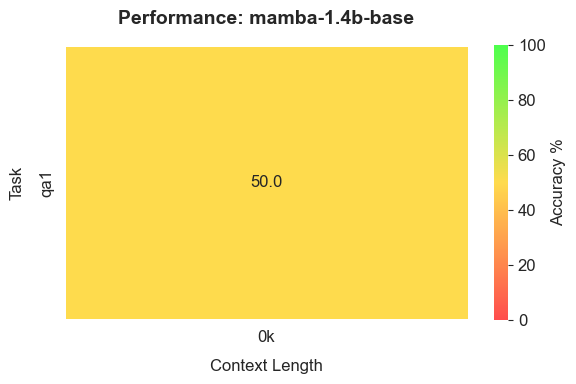

In [11]:
# ==============================================================================
# 7. RESULTS VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from pathlib import Path

# Define the specific model results to analyze
# This must match the 'MODEL_NAME' variable from Block 6
CURRENT_MODEL_NAME = "mamba-1.4b-adapter" if USE_ADAPTER else "mamba-1.4b-base"
RESULTS_DIR = Path(RESULTS_FOLDER) / CURRENT_MODEL_NAME

print(f"📊 Analyzing results from: {RESULTS_DIR}")

# Initialize accuracy matrix (Rows=Tasks, Cols=Lengths)
accuracy_matrix = np.zeros((len(TASKS), len(SPLIT_NAMES)))

for j, task in enumerate(TASKS):
    for i, split_name in enumerate(SPLIT_NAMES):
        
        # 1. Construct Path (Matches Block 6 naming convention)
        csv_path = RESULTS_DIR / f"{task}_{split_name}.csv"
        
        if not csv_path.exists():
            print(f'⚠️ Missing file: {csv_path} (Did you run the eval loop?)')
            accuracy_matrix[j, i] = 0 
            continue

        try:
            # 2. Load Data
            df = pd.read_csv(csv_path)
            
            # 3. Read Accuracy
            # We already calculated the 'correct' column in Block 6, so we just average it.
            if 'correct' in df.columns:
                acc = df['correct'].mean() * 100
                accuracy_matrix[j, i] = acc
            else:
                print(f"❌ Error: Column 'correct' missing in {csv_path}")
                accuracy_matrix[j, i] = 0
            
        except Exception as e:
            print(f"Error processing {task}/{split_name}: {e}")
            accuracy_matrix[j, i] = 0

# --- Plotting ---
print("\nAccuracy Matrix (%):")
print(accuracy_matrix)

# Setup Plot Style
plt.rc('font', size=12)
# Custom Red-Yellow-Green Colormap (Traffic Light style)
cmap = LinearSegmentedColormap.from_list('ryg', ["#ff4d4d", "#ffdb4d", "#4dff4d"], N=256)

# Dynamic Figure Size
fig, ax = plt.subplots(figsize=(max(6, len(SPLIT_NAMES)*2), max(4, len(TASKS)*1)))

# Create Heatmap
sns.heatmap(accuracy_matrix, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".1f",
            linewidths=1, linecolor='white',
            xticklabels=SPLIT_NAMES, yticklabels=TASKS, ax=ax,
            cbar_kws={'label': 'Accuracy %'})

ax.set_title(f'Performance: {CURRENT_MODEL_NAME}', pad=15, fontsize=14, fontweight='bold')
ax.set_xlabel('Context Length', labelpad=10)
ax.set_ylabel('Task', labelpad=10)

plt.tight_layout()
plt.show()